In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import glob
import matplotlib.pyplot as plt


/Users/lshahsha/Documents/GitHub/selective_recruitment/.sr-venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Model evaluation results


* Basal Ganglia region was defined using Harvard oxford atlas on 2mm resolution

* Cortical data was tesselated into 1002 parcels/per hemisphere. Parcels have the same size

* Y = XW + E. Y voxel data for BG, X tesselated cortical data, estimated connectivity weights

* Performance accuracy is defined as the cosine similarity between observed and predicted activity pattern


## trained and evaluated on individual subjects

* Models were trained and evaluated on individual subject
    * trained on ses-s1 (task set A in paper) on each individual subject. For each subject, it was then evaluated on ses-s2 (task set B in paper) for the same subject.

In [8]:
# get the best performing model for Md, L1 and L2 regression evaluated on individual subjects trained on s1
d=rm.comb_eval(models=['Md_s1_glasser_ind', 'Md_s1_ind'],
                  eval_t = 'eval', 
                  eval_data=["MDTB"], 
                  eval_ses='s2', 
                  subcortex='MNIAsymBg2',
                  methods =['L2regression', 'L1regression', 'WTA'])
d['model'].fillna('avg',inplace=True)
d['nanY']=np.isnan(d.noiseceiling_Y)
d['nanXY']=np.isnan(d.noiseceiling_XY)
d['nanXR']=np.isnan(d.noise_X_R)

variables in the dataframe:

* noise_X_R: reliability (correlation) of predicted values across sessions
* noise_X_R2: squared correlation between predicted values across sessions
* noise_Y_R: reliability (correlation) of observed values across sessions
* noise_Y_R2: squared correlation between observed values across sessions

<Figure size 1200x400 with 0 Axes>

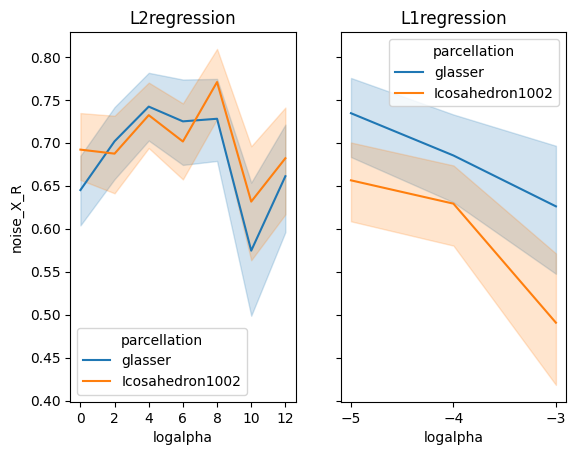

In [9]:
# find the best model: the model that leads to highest predictive accuracy across subjects
methods = ["L2regression", "L1regression"]
fig = plt.figure(figsize=(12,4))
_, ax = plt.subplots(1,2, sharey = True)
for i,method in enumerate(methods):
    g = sns.lineplot(x='logalpha', y='noise_X_R', data=d.loc[d.method == method], ax=ax[i], hue = "parcellation")
    if method == "L2regression":
        g.set_xticks([0, 2, 4, 6, 8, 10, 12])        
    else:
        g.set_xticks([-5, -4, -3])
    # set the tile
    g.set_title(method)

<Figure size 1200x400 with 0 Axes>

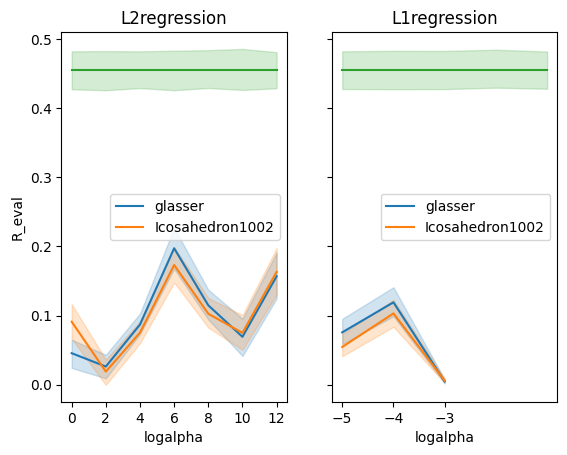

In [10]:
# find the best model: the model that leads to highest predictive accuracy across subjects
methods = ["L2regression", "L1regression"]
fig = plt.figure(figsize=(12,4))
_, ax = plt.subplots(1,2, sharey = True)
for i,method in enumerate(methods):
    g = sns.lineplot(x='logalpha', y='R_eval', data=d.loc[d.method == method], ax=ax[i], hue = "parcellation")
    g = sns.lineplot(x=d.logalpha.loc[d.method == method], y= d['noiseceiling_Y'].loc[d.method == method].values, ax=ax[i])
    if method == "L2regression":
        g.set_xticks([0, 2, 4, 6, 8, 10, 12])        
    else:
        g.set_xticks([-5, -4, -3])
    # set the tile
    g.set_title(method)


In [12]:
# determine best logalpha for each model 
best_model = pd.pivot_table(d,index=['method', 'parcellation'],columns=['logalpha'],values=['R_eval'],aggfunc='mean')
best_model = best_model.idxmax(axis=1).reset_index()
best_model

,method,parcellation,0
0,L1regression,Icosahedron1002,"(R_eval, -4.0)"
1,L1regression,glasser,"(R_eval, -4.0)"
2,L2regression,Icosahedron1002,"(R_eval, 6.0)"
3,L2regression,glasser,"(R_eval, 6.0)"


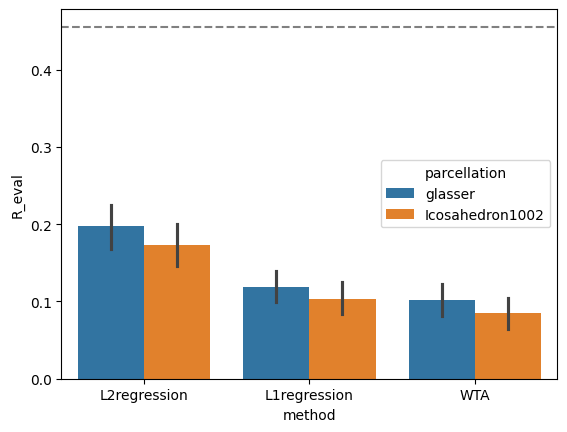

In [15]:
# model evaluation
# calculate R_eval divided by noise ceiling
d['R_eval_adj_Y'] = d['R_eval'] / d['noiseceiling_Y']
dd = d.loc[((d.logalpha == 6) & (d.method == "L2regression")) | ((d.logalpha == -4) & (d.method == "L1regression")) | ((d.method == "WTA"))]
g = sns.barplot(dd, x='method', y='R_eval', hue='parcellation')
ny = dd.noiseceiling_Y.mean()
plt.axhline(ny, color='gray', linestyle='--')


## Group connectivity

* Models were trained on individual subjects.
    * trained on ses-s1 (task set A in paper) on each individual subject.
    * evaluated on ses-s2: group connectivity was calculated in a leave-one-subject-out fashion - group was calculated by averaging over all but one subject